In [1]:
import torch
import pandas as pd
import numpy as np
import torch
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


def drop_function(df,features):
    list_1=list(features["col_name"][:20])
    for i in(list_1):
        df=df.drop(i,axis=1)
    n_features=len(list(df.columns))
    return df,n_features

def get_ohe_data(df):
    
    df_int = df.select_dtypes(['float', 'integer']).values
    continuous_columns_list = list(df.select_dtypes(['float', 'integer']).columns)
    ##############################################################
    scaler = QuantileTransformer(n_quantiles=2000, output_distribution='uniform')
    df_int = scaler.fit_transform(df_int)

    df_cat = df.select_dtypes('object') 
    df_cat_names = list(df.select_dtypes('object').columns)
    numerical_array = df_int
    ohe = OneHotEncoder()
    ohe_array = ohe.fit_transform(df_cat)

    cat_lens = [i.shape[0] for i in ohe.categories_]
    discrete_columns_ordereddict = OrderedDict(zip(df_cat_names, cat_lens))


    final_array = np.hstack((numerical_array, ohe_array.toarray()))
    return ohe, scaler, discrete_columns_ordereddict, continuous_columns_list, final_array


def get_original_data(df_transformed, df_orig, ohe, scaler):
    # df_int = df_orig.select_dtypes(['float','integer'])
    df_ohe_int = df_transformed[:, :df_orig.select_dtypes(['float', 'integer']).shape[1]]
    df_ohe_int = scaler.inverse_transform(df_ohe_int)
  
    # df_income = df_transformed[:,-1]
    # df_ohe_cats = np.hstack((df_ohe_cats, df_income.reshape(-1,1)))
    df_int = pd.DataFrame(df_ohe_int, columns=df_orig.select_dtypes(['float', 'integer']).columns)
    return df_int


def prepare_data(df, batch_size):
    #df = pd.concat([df_train, df_test], axis=0)

    ohe, scaler, discrete_columns, continuous_columns, df_transformed = get_ohe_data(df)


    input_dim = df_transformed.shape[1]

    #from sklearn.model_selection import train_test_split
    #################
    X_train, X_test = train_test_split(df_transformed,test_size=0.1, shuffle=True) #random_state=10)
    #X_train = df_transformed[:df_train.shape[0],:]
    #X_test = df_transformed[df_train.shape[0]:,:]

    data_train = X_train.copy()
    data_test = X_test.copy()

    data = torch.from_numpy(data_train).float()


    train_ds = TensorDataset(data)
    train_dl = DataLoader(train_ds, batch_size = batch_size, drop_last=True)
    return ohe, scaler, input_dim, discrete_columns, continuous_columns ,train_dl, data_train, data_test

def get_gradient(crit, real, fake, epsilon):
    mixed_data = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_data)

    gradient = torch.autograd.grad(
        inputs=mixed_data,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def get_gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)

    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty

def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)

    return gen_loss


def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    return crit_loss

In [2]:
import torch
import torch.nn.functional as f
from torch import nn
class Generator(nn.Module):
    def __init__(self, input_dim, continuous_columns, discrete_columns):
        super(Generator, self).__init__()
        self._input_dim = input_dim
        self._discrete_columns = discrete_columns
        self._num_continuous_columns = len(continuous_columns)

        self.lin1 = nn.Linear(self._input_dim, self._input_dim)
        self.lin_numerical = nn.Linear(self._input_dim, self._num_continuous_columns)

        self.lin_cat = nn.ModuleDict()
        for key, value in self._discrete_columns.items():
            self.lin_cat[key] = nn.Linear(self._input_dim, value)
        

    def forward(self, x):
        x = torch.relu(self.lin1(x))
        # x = f.leaky_relu(self.lin1(x))
        # x_numerical = f.leaky_relu(self.lin_numerical(x))
        x_numerical = f.relu(self.lin_numerical(x))
        x_cat = []
        for key in self.lin_cat:
            x_cat.append(f.gumbel_softmax(self.lin_cat[key](x), tau=0.2))
        x_final = torch.cat((x_numerical, *x_cat), 1)
        return x_final


class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self._input_dim = input_dim
        # self.dense1 = nn.Linear(109, 256)
        self.dense1 = nn.Linear(self._input_dim, self._input_dim)
        self.dense2 = nn.Linear(self._input_dim, self._input_dim)
        # self.dense3 = nn.Linear(256, 1)
        # self.drop = nn.Dropout(p=0.2)
        # self.activation = nn.Sigmoid()

    def forward(self, x):
        x = f.leaky_relu(self.dense1(x))
        # x = self.drop(x)
        # x = f.leaky_relu(self.dense2(x))
        x = f.leaky_relu(self.dense2(x))
        # x = self.drop(x)
        return x

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
cuda
model =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
epoch 1


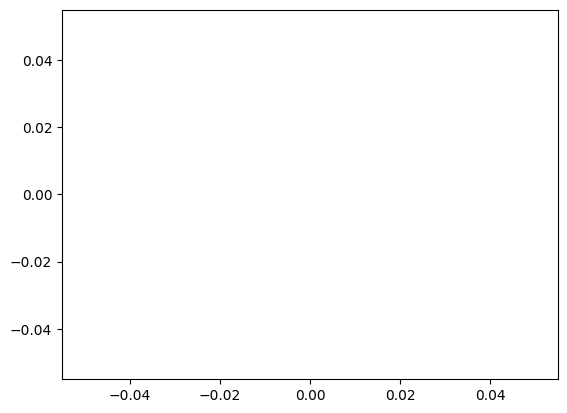

epoch 2


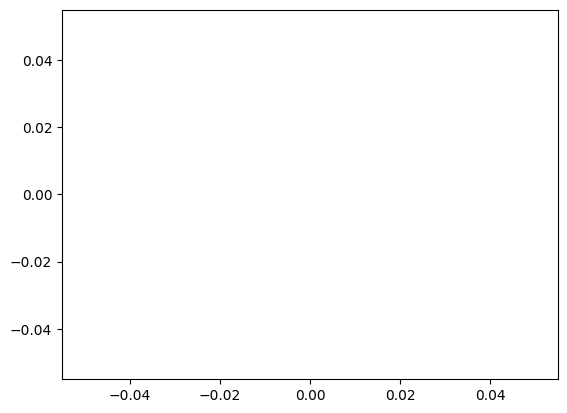

epoch 3


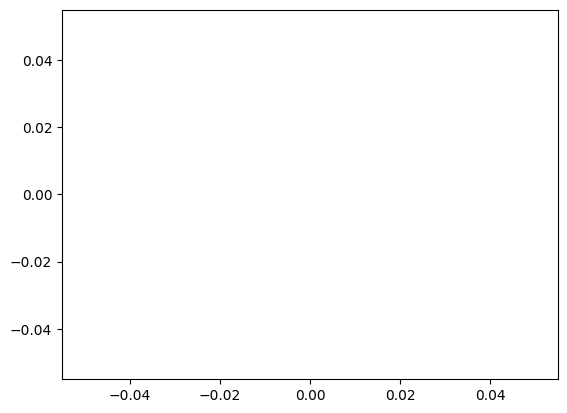

epoch 4


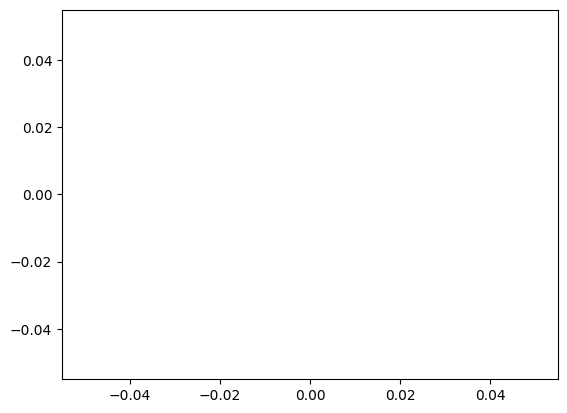

epoch 5


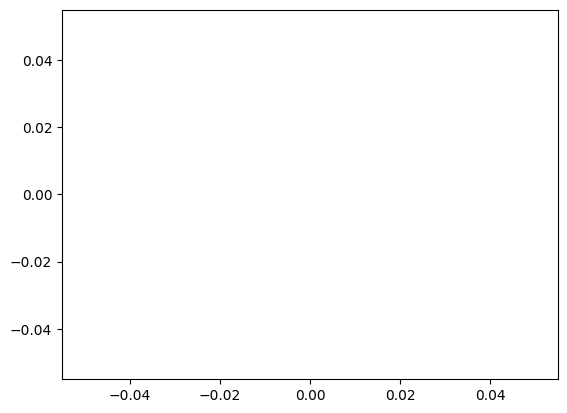

epoch 6


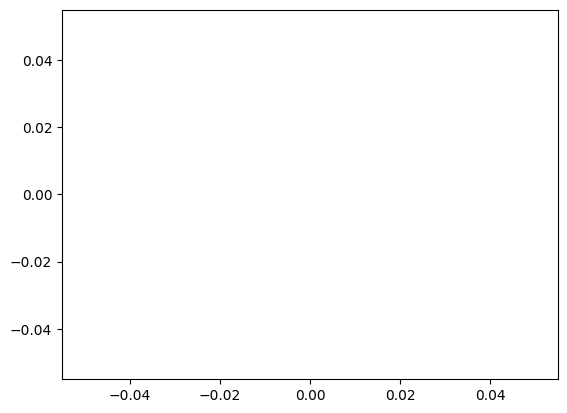

epoch 7


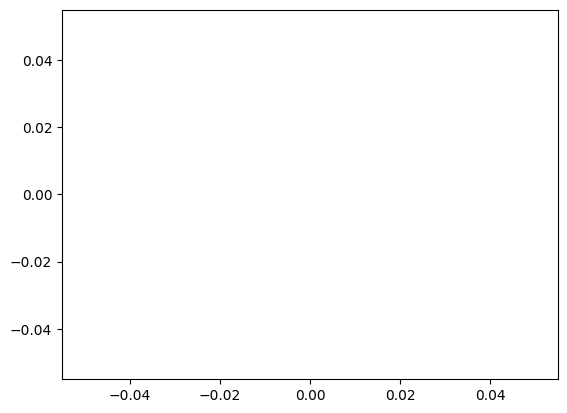

epoch 8


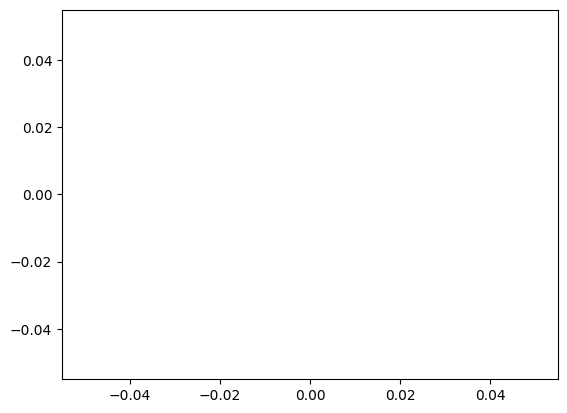

epoch 9


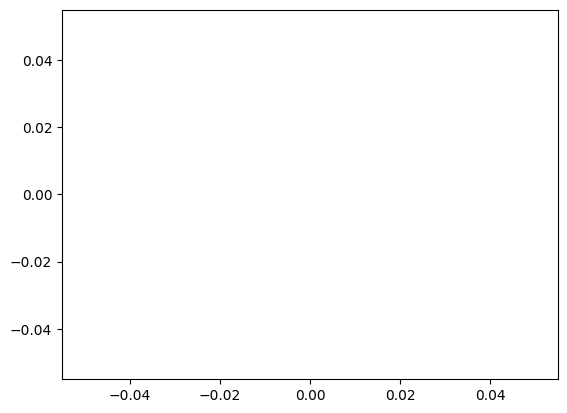

epoch 10


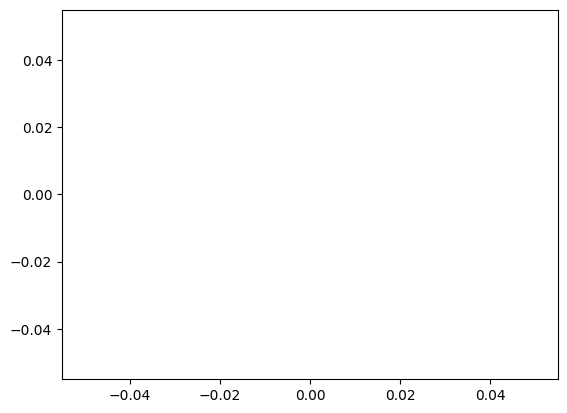

epoch 11


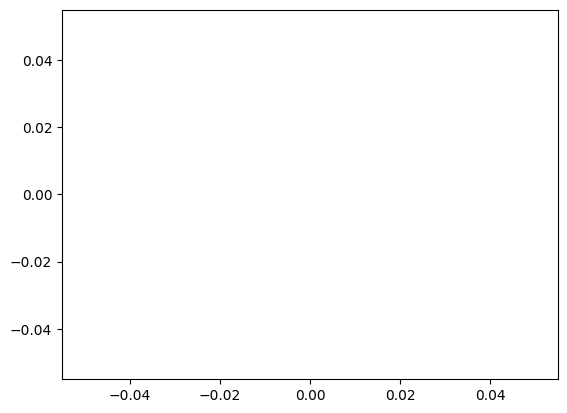

epoch 12


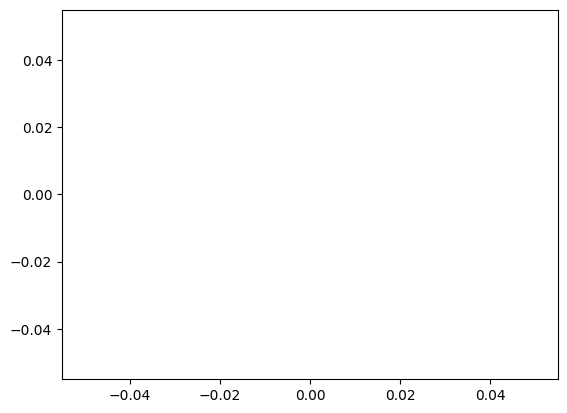

epoch 13


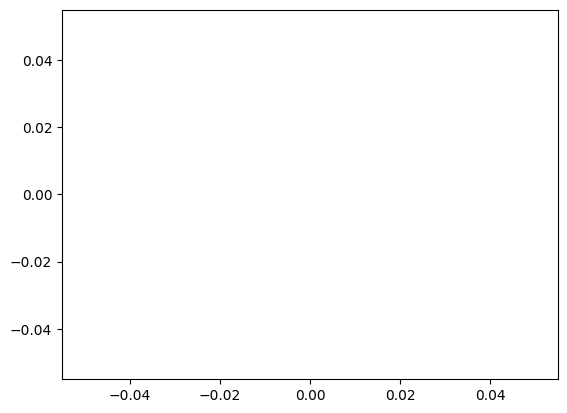

epoch 14


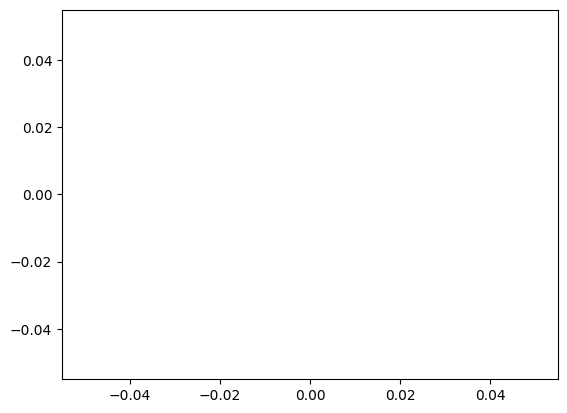

epoch 15


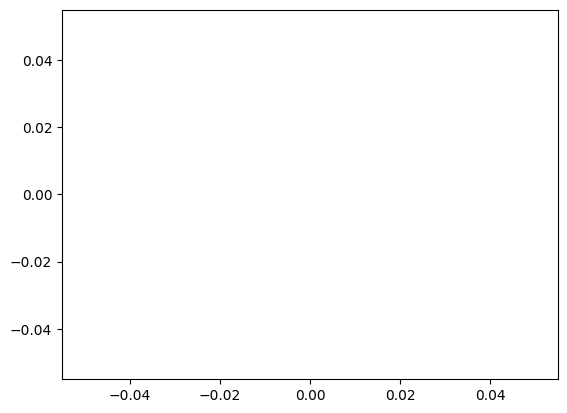

epoch 16


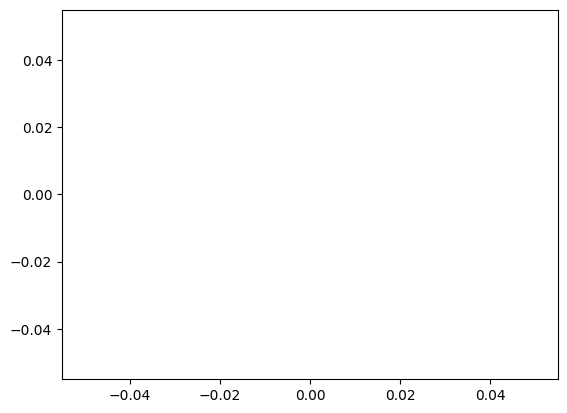

epoch 17


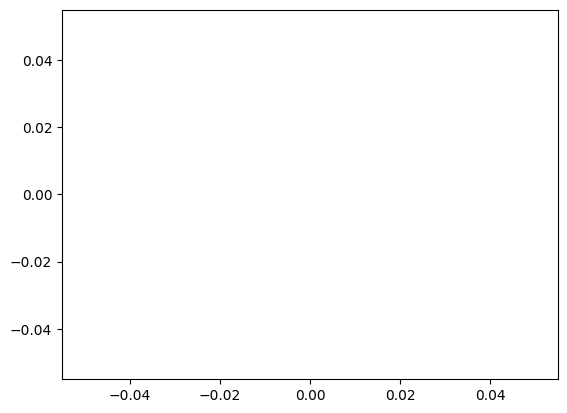

epoch 18


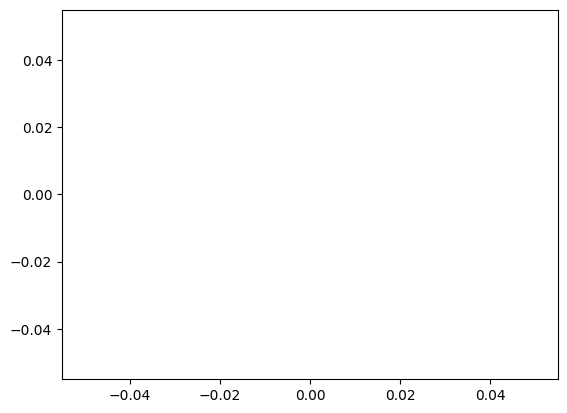

epoch 19


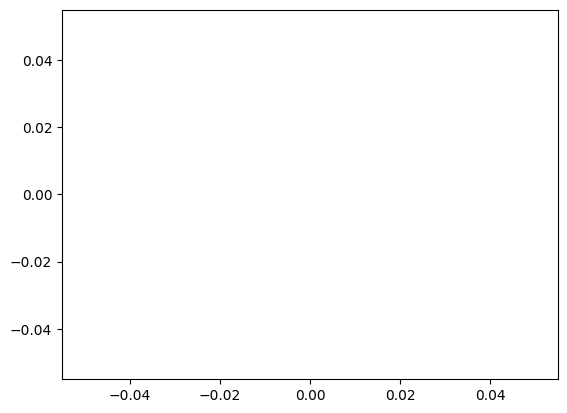

epoch 20


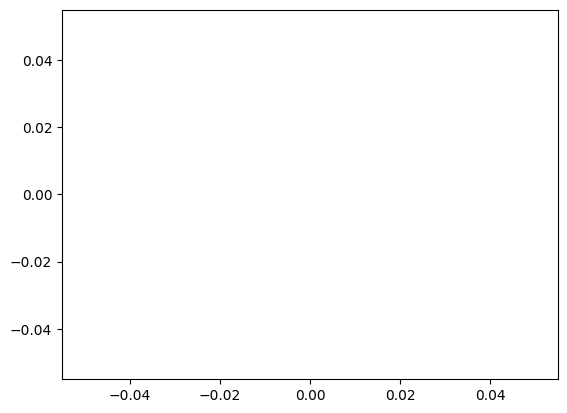

epoch 21


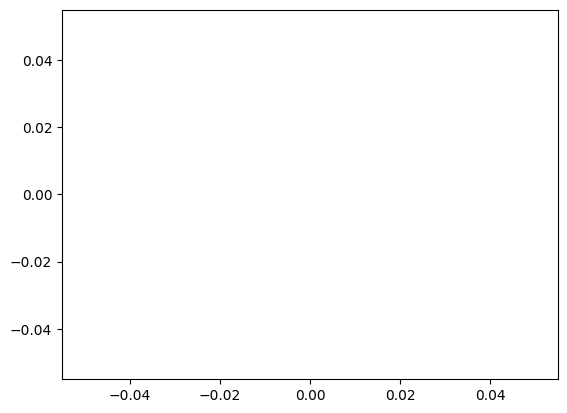

epoch 22


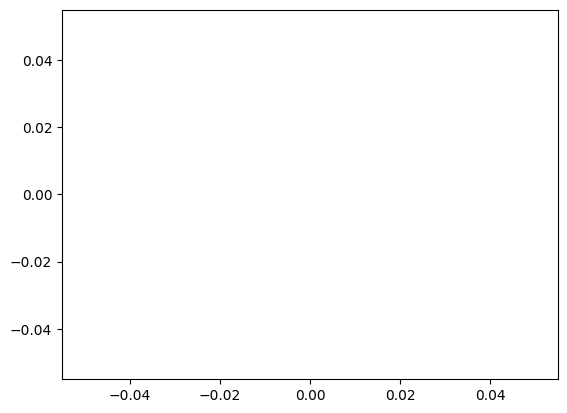

epoch 23


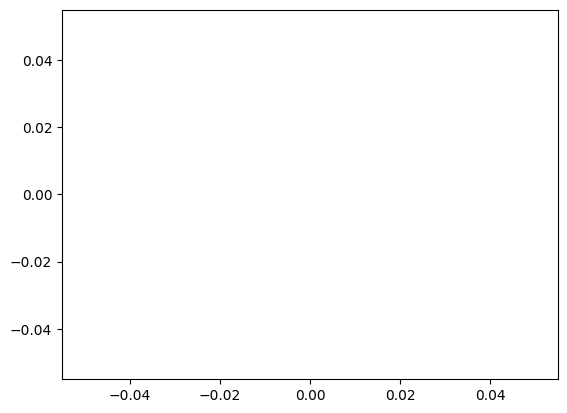

epoch 24


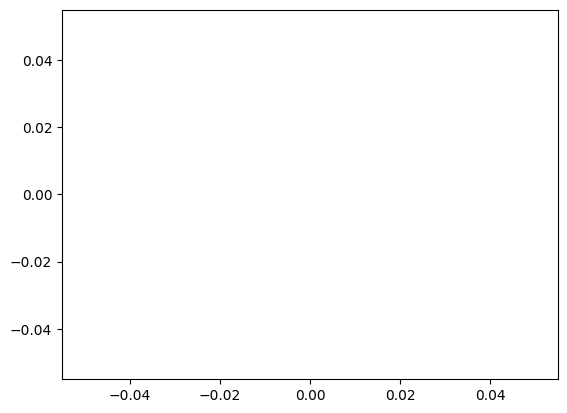

epoch 25


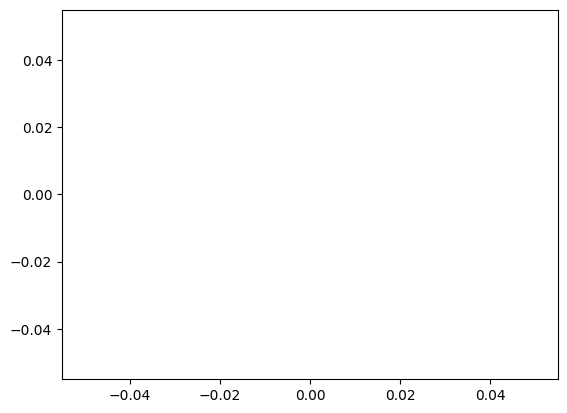

epoch 26


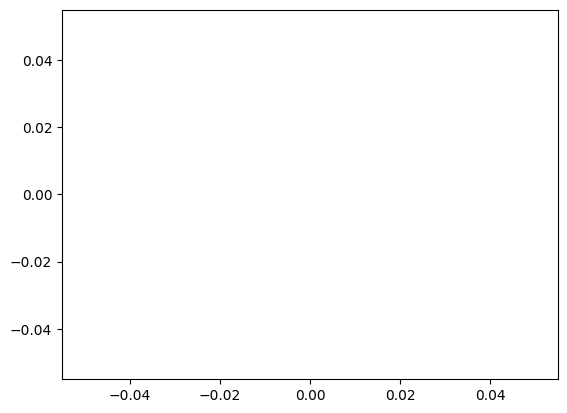

epoch 27


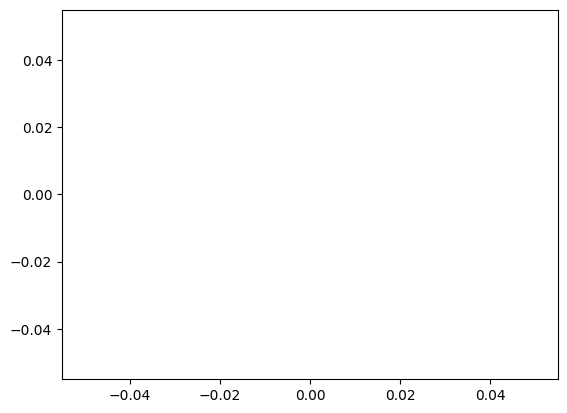

epoch 28


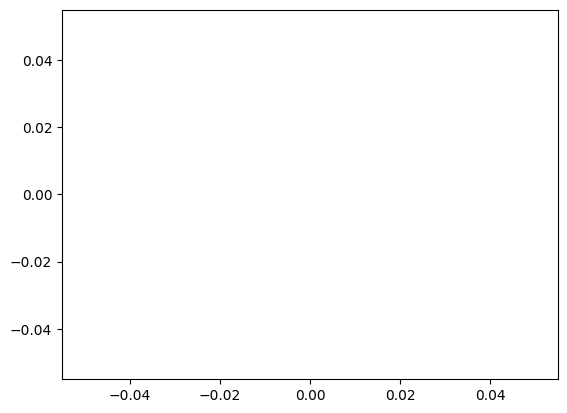

epoch 29


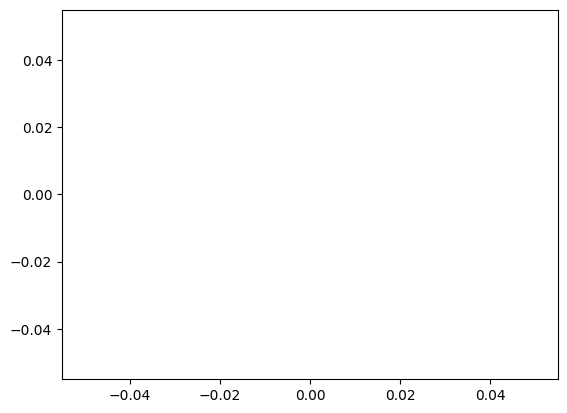

epoch 30


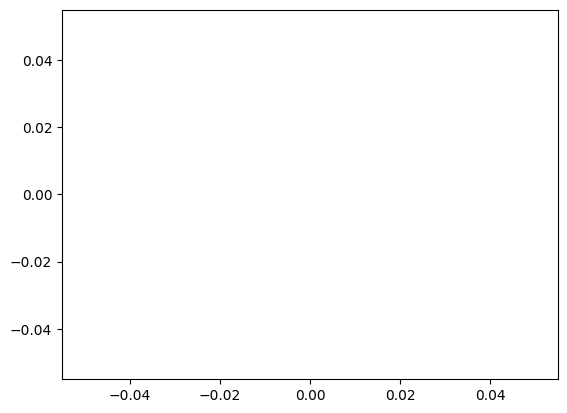

epoch 31


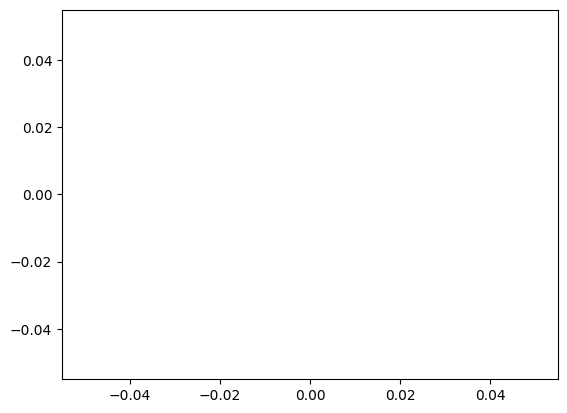

epoch 32


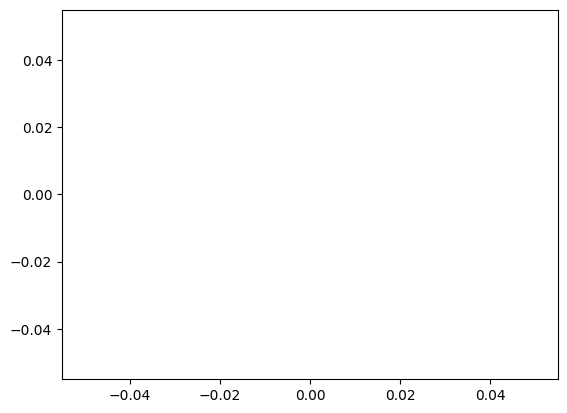

epoch 33


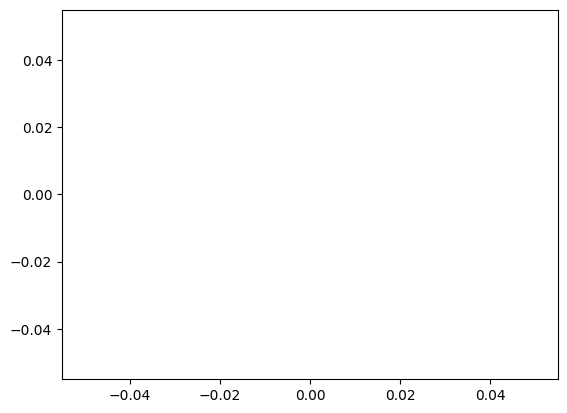

epoch 34


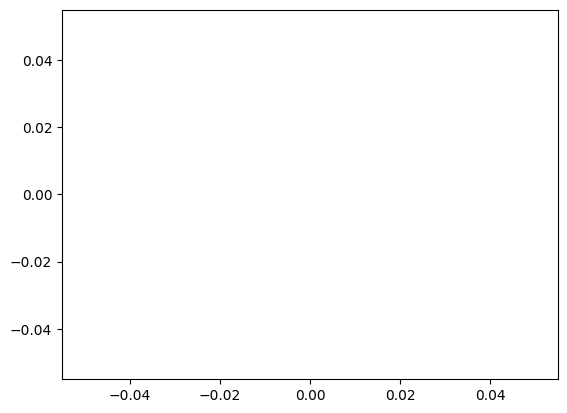

epoch 35


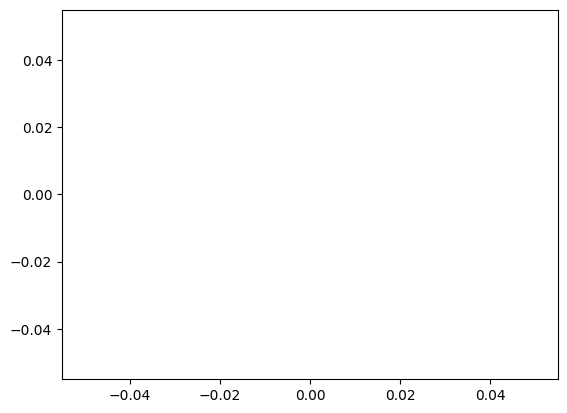

epoch 36


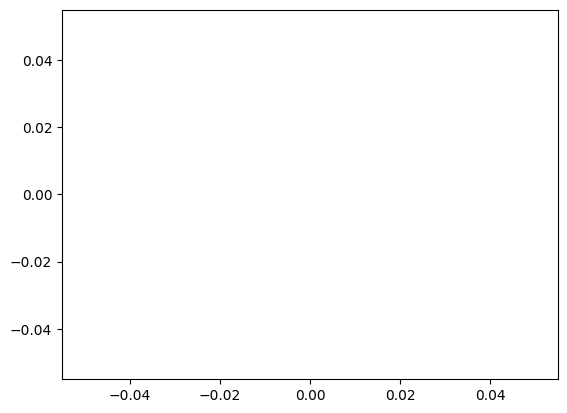

epoch 37


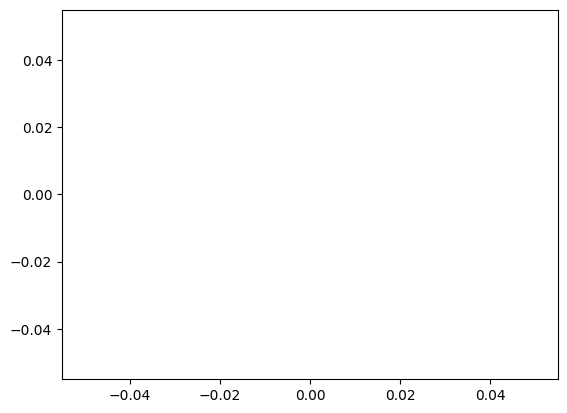

epoch 38


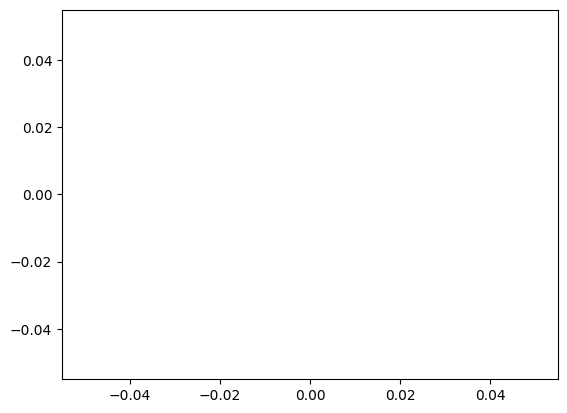

epoch 39


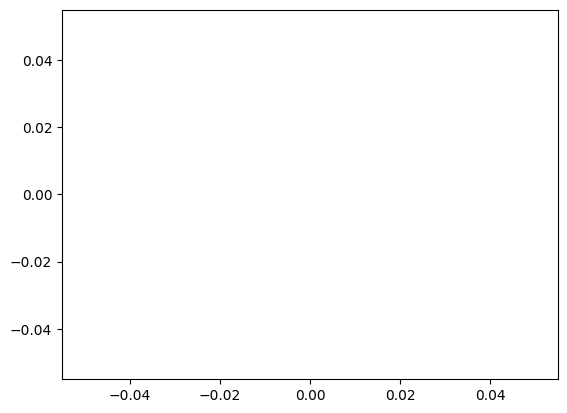

epoch 40


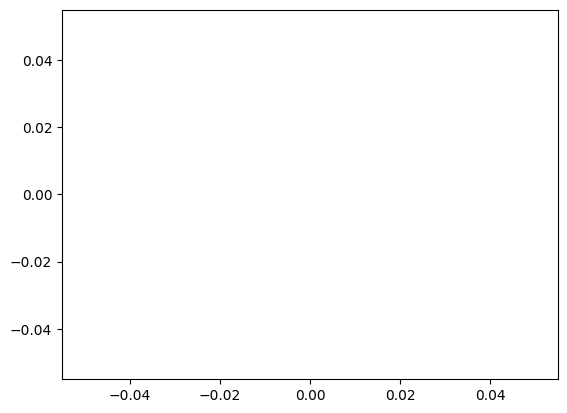

epoch 41


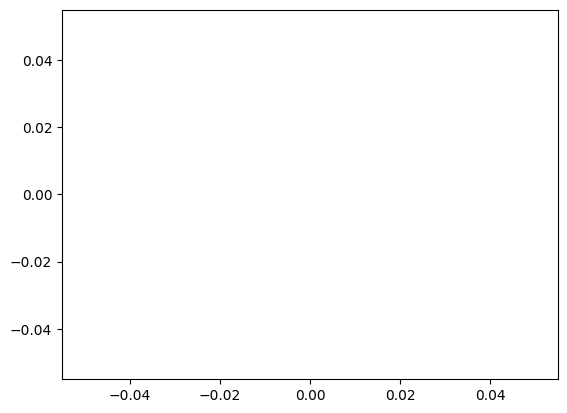

epoch 42


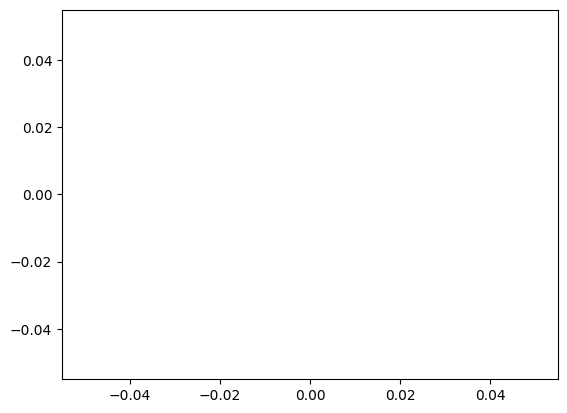

epoch 43


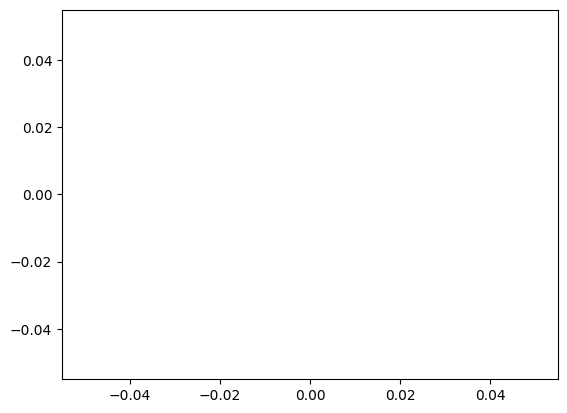

epoch 44


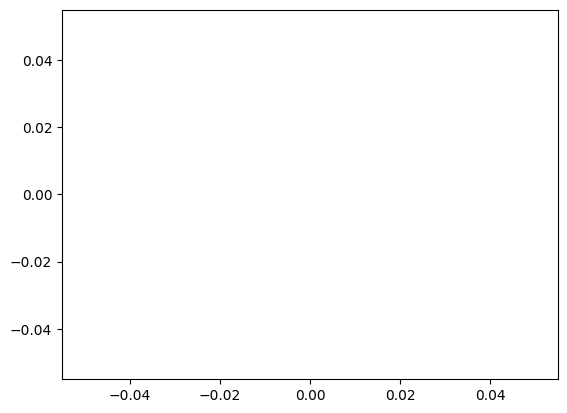

epoch 45


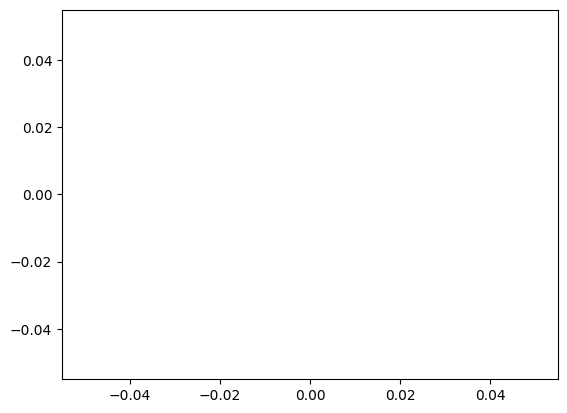

epoch 46


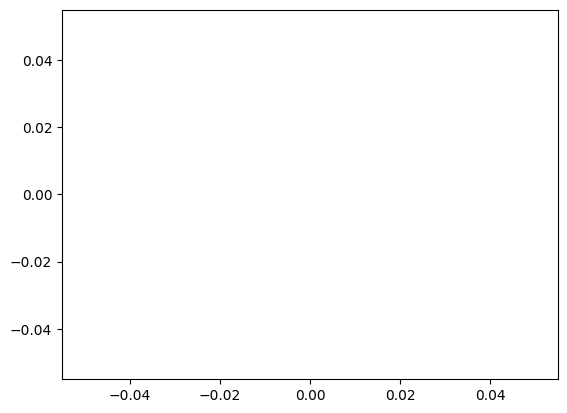

epoch 47


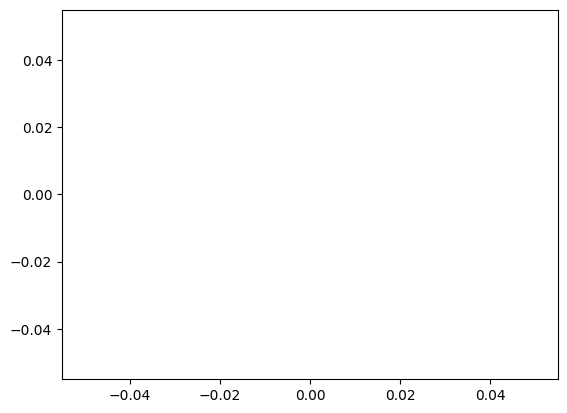

epoch 48


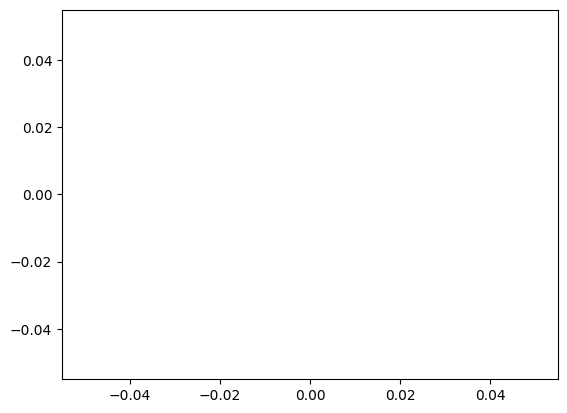

epoch 49


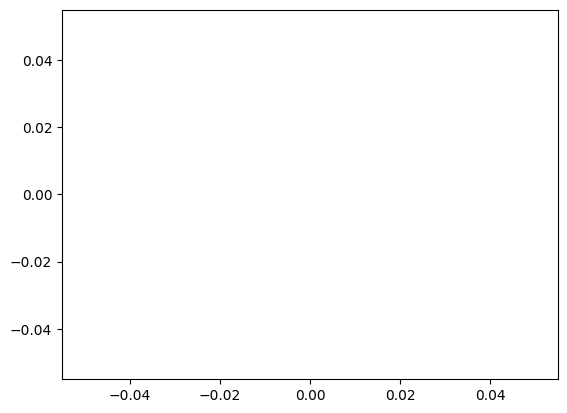

epoch 50


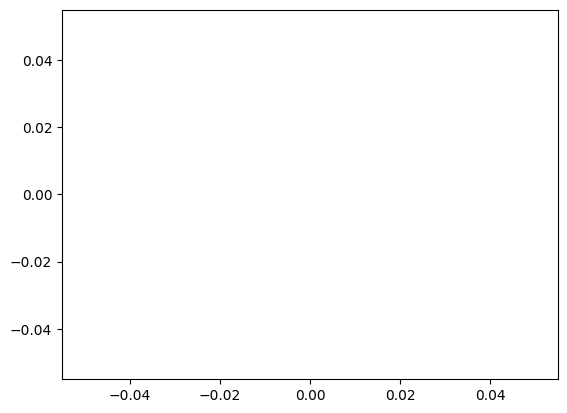

epoch 51


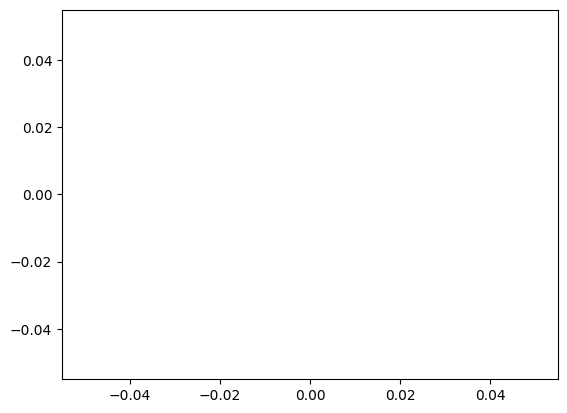

epoch 52


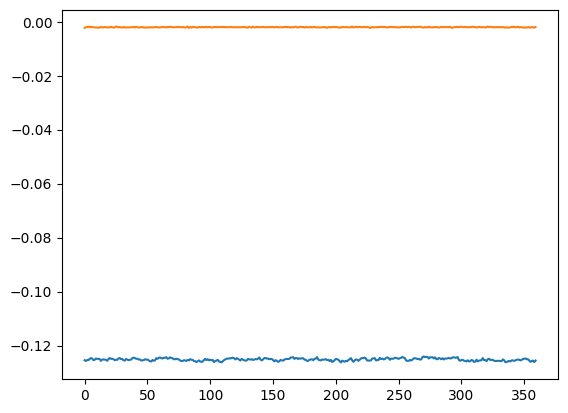

epoch 53


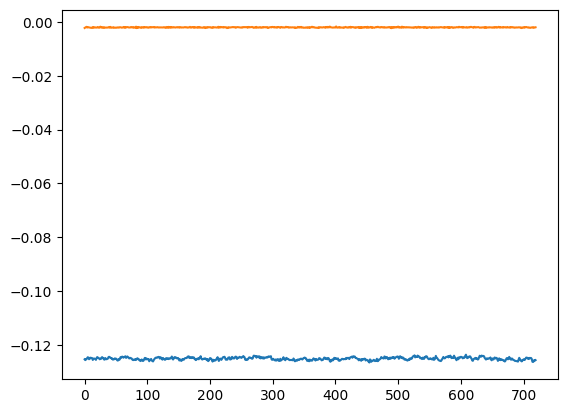

epoch 54


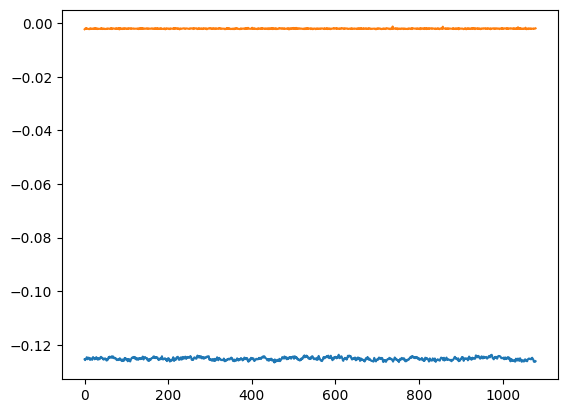

epoch 55


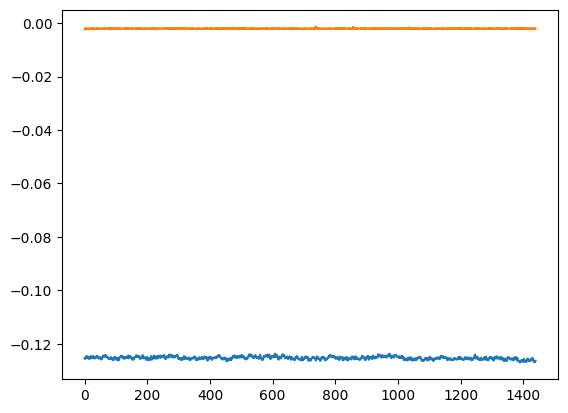

epoch 56


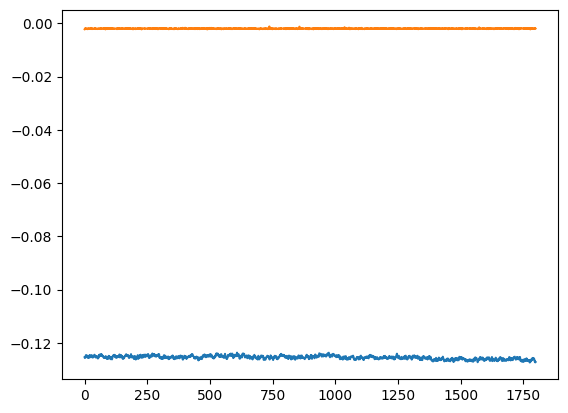

epoch 57


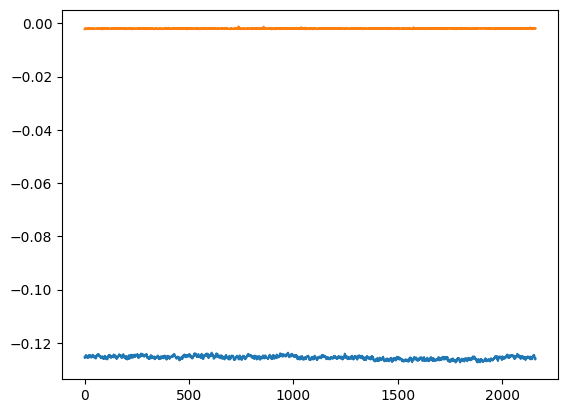

epoch 58


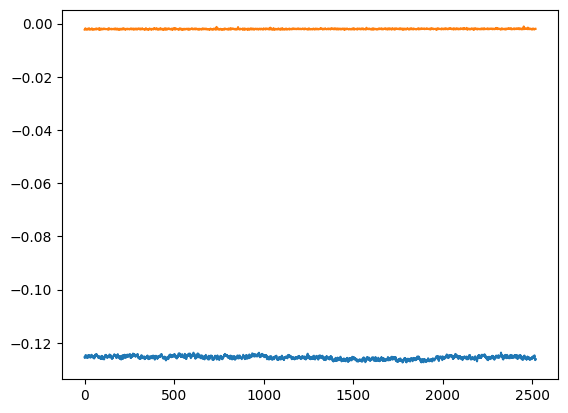

epoch 59


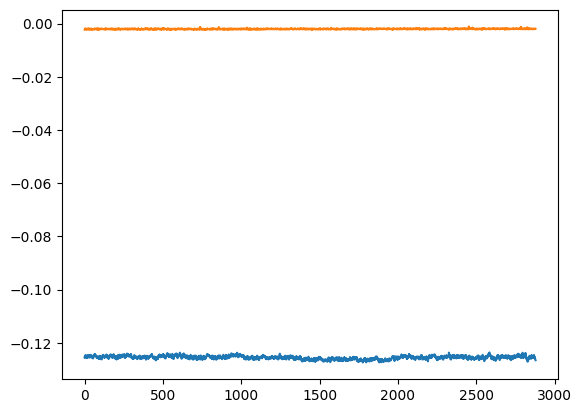

epoch 60


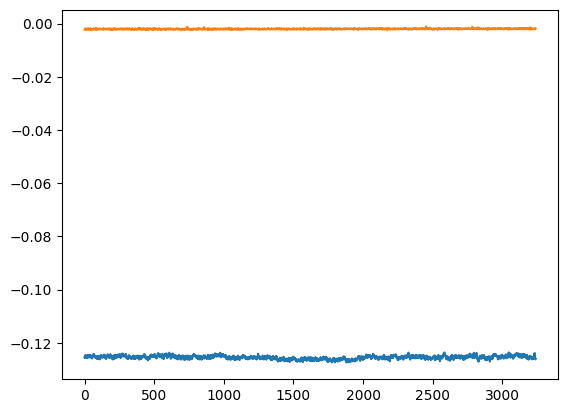

epoch 61


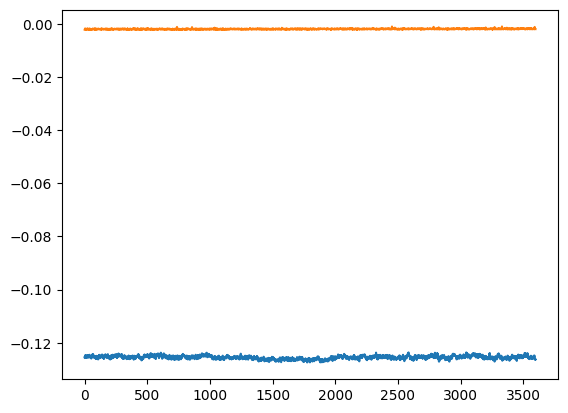

epoch 62


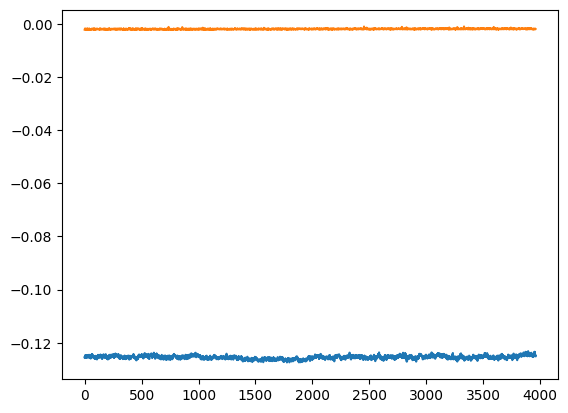

epoch 63


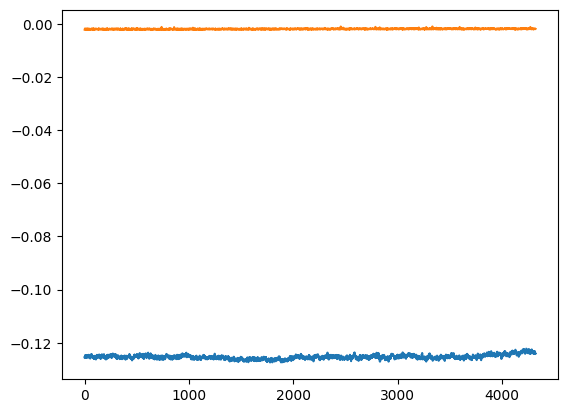

epoch 64


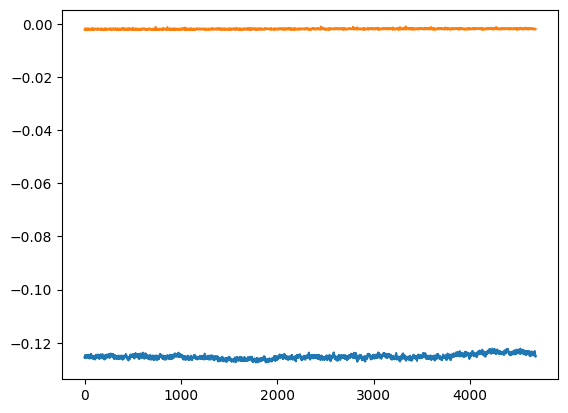

epoch 65


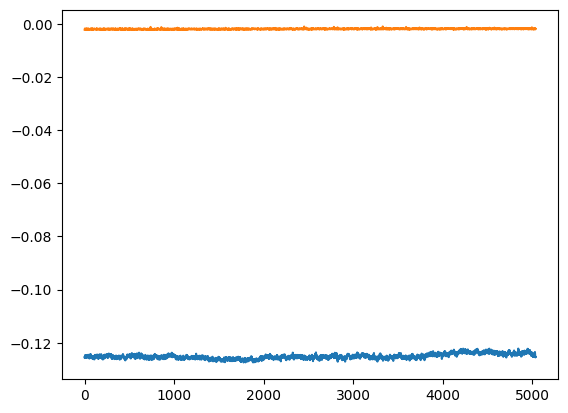

epoch 66


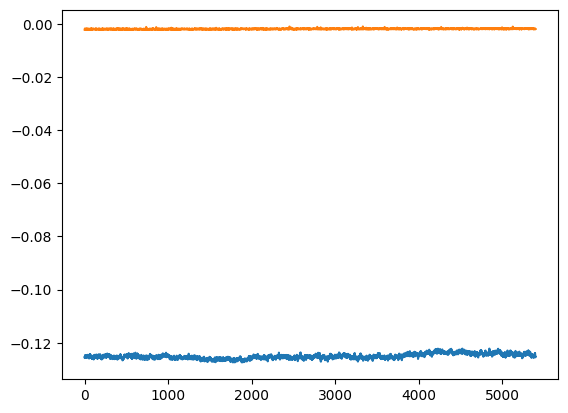

epoch 67


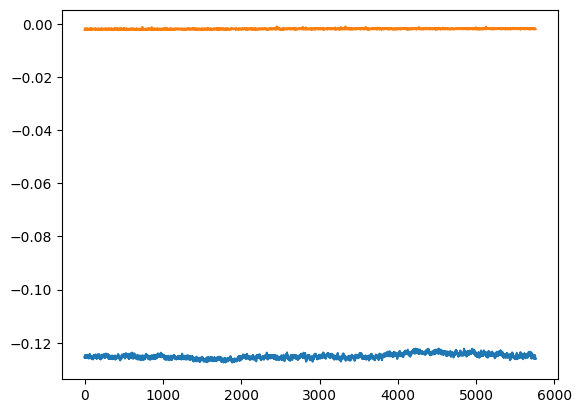

epoch 68


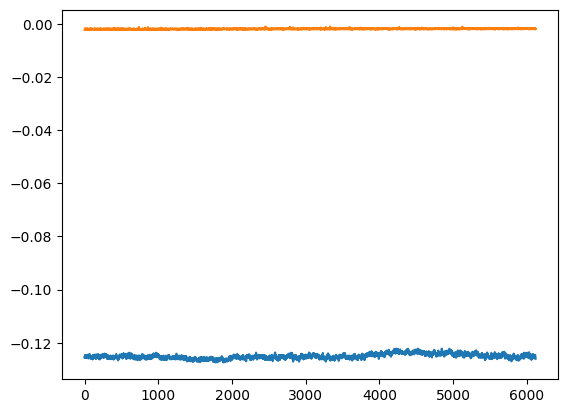

epoch 69


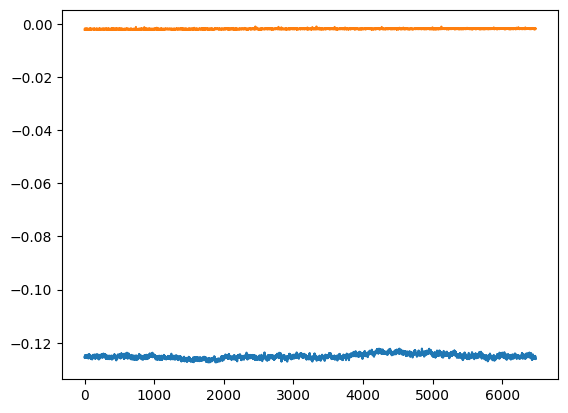

epoch 70


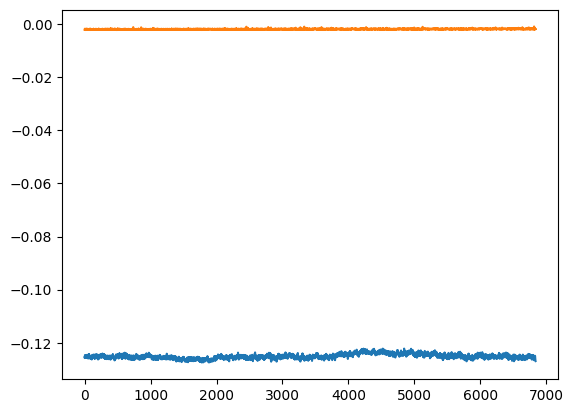

In [3]:
import torch
import torch.nn.functional as f
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

display_step = 50

def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)

    return gen_loss


def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    return crit_loss

def train(df,generator_path,critic_path ,epochs=500, batch_size=32):
    ohe, scaler, input_dim, discrete_columns, continuous_columns, train_dl, data_train, data_test =prepare_data(df, batch_size)

    generator = Generator(input_dim, continuous_columns, discrete_columns).to(device)
    critic = Critic(input_dim).to(device)
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    crit_optimizer = torch.optim.Adam(critic.parameters(), lr=0.0002, betas=(0.5, 0.999))
    print("model = ", gen_optimizer)
    print("optimizer = ", gen_optimizer)

    # loss = nn.BCELoss()
    critic_losses = []
    generator_losses = []
    cur_step = 0
    for i in range(epochs):
        # j = 0
        print("epoch {}".format(i + 1))
        ############################
        for data in train_dl:
            data[0] = data[0].to(device)
            # j += 1
            loss_of_epoch_G = 0
            loss_of_epoch_D = 0
            crit_repeat = 4
            mean_iteration_critic_loss = 0
            for k in range(crit_repeat):
                # training the critic
                crit_optimizer.zero_grad()
                fake_noise = torch.randn(size=(batch_size, input_dim), device=device).float()
                fake = generator(fake_noise)

                crit_fake_pred = critic(fake.detach())
                crit_real_pred = critic(data[0])

                epsilon = torch.rand(batch_size, input_dim, device=device, requires_grad=True)
                gradient = get_gradient(critic, data[0], fake.detach(), epsilon)
                gp = get_gradient_penalty(gradient)

                crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda=10)

                mean_iteration_critic_loss += crit_loss.item() / crit_repeat
                crit_loss.backward(retain_graph=True)
                crit_optimizer.step()
            #############################
            if cur_step > 50:
                critic_losses += [mean_iteration_critic_loss]
                # wandb.log({"Critic_loss": critic_losses})

            #############################

            gen_optimizer.zero_grad()
            fake_noise_2 = torch.randn(size=(batch_size, input_dim), device=device).float()
            fake_2 = generator(fake_noise_2)
            crit_fake_pred = critic(fake_2)

            gen_loss = get_gen_loss(crit_fake_pred)
            gen_loss.backward()

                # Update the weights
            gen_optimizer.step()

    
            
            # Keep track of the average generator loss
            #################################
            if cur_step > 50:
                generator_losses += [gen_loss.item()]
                # wandb.log({"generator_loss": generator_losses})
                
                

        if cur_step % display_step == 0 and cur_step > 0:
            

            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            # print("Step {}: Generator loss: {}, critic loss: {}".format(cur_step, gen_mean, crit_mean))
        step_bins = 20
        num_examples = (len(generator_losses) // step_bins) * step_bins
        plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                )
        plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                )
        plt.savefig('GanResults.png',bbox_inches = 'tight')
        plt.show()

	    
        cur_step += 1
        torch.save(generator,generator_path )
        torch.save(critic,critic_path )
    return generator, critic, ohe, scaler, data_train, data_test, input_dim


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(1))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
print(device)


def train_plot(df, epochs, batchsize):
    generator, critic, ohe, scaler, data_train, data_test, input_dim = train(df,"CriticAllclassestest.pth","GeneratorAllclassestest.pth",epochs, batchsize)
    return generator, critic, ohe, scaler, data_train, data_test, input_dim

size_of_fake_data=200000
num_epochs=70
batch_size=64

df=pd.read_csv("/kaggle/input/net-traffic/combined.csv")
fe=pd.read_csv("/kaggle/input/net-traffic/DDoS_Functional_Features.csv")
# df=df.loc[df['Label']==1]s
# df=df.drop("Label",axis=1)
# df,n=drop_function(df,fe)

fake_name="generated_data.csv"
generator, critic, ohe, scaler, data_train, data_test, input_dim = train_plot(df,num_epochs, batch_size)

fake_numpy_array = generator(torch.randn(size=(size_of_fake_data, input_dim), device=device)).cpu().detach().numpy()
fake_df = get_original_data(fake_numpy_array, df, ohe, scaler)
fake_df = fake_df[df.columns]
fake_df.to_csv(fake_name, index=False) 